# Actionable Insights from Lululemon Reviews - Preprocessing and Topic Modeling

Amanda Cheney  
Metis Project 4  
Part 3 of 4    
November 13, 2020  

**Objective**

Natural language processing & unsupervised learning exploration of customer reviews of lululemon’s best-selling sports bras to derive actionable insights for product development and management team and develop a recommender system to provide a curated collection of reviews specifically tailored to customer product needs.

**Data Sources**   
9,000+ reviews of all 13 of Lululemon's bestselling sports bras, collected using Selenium.

**This Notebook**   
Utilizes Spacy for text preprocessing and lemmatization. Compares different combinations of TFIDF and CV with LSA, LDA and NMF before settling on using TFIDF and NMF for topic modelling. Select 6 final topics using scree, cumulative variation explanined and t-SNE plots to validate optimal number of topics.

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Spacy for preprocessing
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# Gensim libraries
from gensim import corpora, models, similarities, matutils

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

#Sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, LatentDirichletAllocation, TruncatedSVD, NMF

#wordcloud
from wordcloud import WordCloud

## Load Data

In [2]:
with open('df_cleaned.pickle', 'rb') as read_file:
    df_cleaned = pickle.load(read_file)

## Implement preprocessing to return clean data 

In [3]:
from preprocessing import make_alphabetic, preprocess_pipe

In [4]:
%%time
my_corpus = []
for doc in df_cleaned.content:
    my_corpus.append(make_alphabetic(doc))

CPU times: user 86.2 ms, sys: 5.2 ms, total: 91.4 ms
Wall time: 96.9 ms


In [5]:
%%time
cleaned_text = preprocess_pipe(my_corpus)

CPU times: user 2.94 s, sys: 67.4 ms, total: 3 s
Wall time: 3.66 s


In [6]:
ct = cleaned_text

In [7]:
df_cleaned['clean_txt'] = ct

In [8]:
clean_df = df_cleaned[df_cleaned['clean_txt'].notna()]

In [9]:
clean_df.shape

(9090, 13)

In [10]:
clean_df.head()

,product_name,product_url,product_list_price,product_avg_rating,title,content,rating,name,date,review counter,num_total_ratings,rev_length,clean_txt
0,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Haven't taken it off,I purchased this bra in the hazy jade color ab...,5,Anonymous,2020-10-31,1,89,203,purchase hazy jade color week ago wear everyda...
1,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,"comfortable, but...","comfortable, but not for small frame/big chest...",3,Ashley Traister,2020-10-31,2,89,107,comfortable small framebig chest strap dig sho...
2,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Amazing,"If it weren't for the price, I would replace a...",5,meaglee321,2020-10-31,3,89,170,price replace amaze material like cloud accura...
3,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Comfort Bra 5*’s,Super soft and comfortable to wear all day. Ot...,5,Craftybayler,2020-10-30,4,89,111,super soft comfortable wear day rub tight wear...
4,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,So comfortable!,I originally bought 2 but I’m buying more. I w...,5,Ash the mail lady,2020-10-30,5,89,324,originally buy buy wear work mail carrier walk...


## Snapshot of the Cleaned Corpus

Before we dive into feature extraction, let's have a look at the top 100 words in the entire clean corpus using a word cloud.

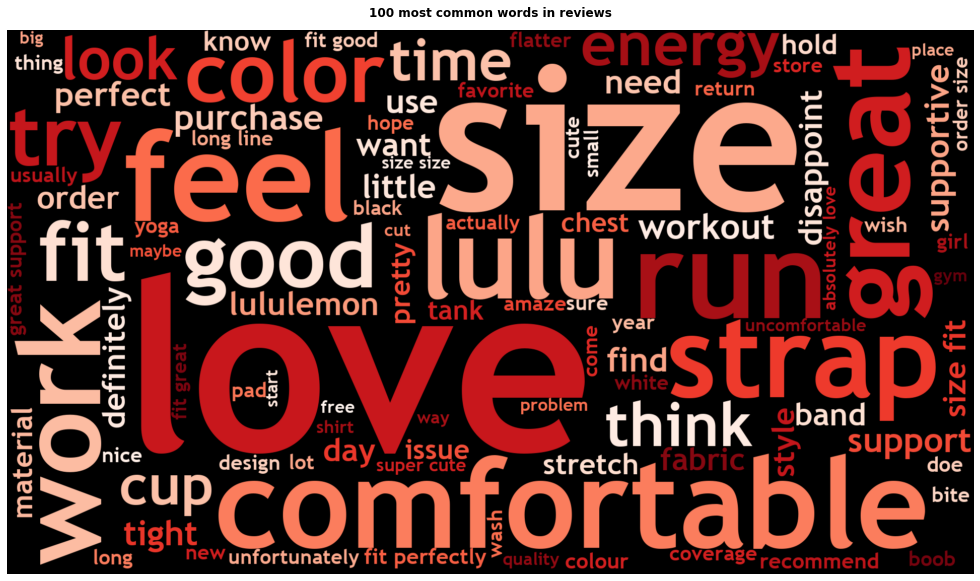

In [11]:
# Join the review.
long_string = ','.join(list(clean_df.clean_txt.values))

my_stops = ['wear', 'buy', 'like']
# Create a WordCloud object
wordcloud = WordCloud(font_path='/Library/Fonts/Trebuchet MS Bold.TTF', stopwords=my_stops, width=1920, height=1080, 
                      background_color="black", max_words=100, contour_width=3, 
                      colormap='Reds', random_state=720)

# Generate a word cloud
wordcloud.generate(long_string)

plt.figure(figsize= (25,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("100 most common words in reviews", pad = 14, weight = 'bold')

plt.show()

Lots of terms one would expect, however, I imagine some the words displayed in the largest font may end up not appearing in our topics when we control for maximum document frequency in our feature extraction below, but time will tell!

# Feature Extraction

Let's try feature extraction using both CountVectorizer and TfidfVectorizer to see how well they pair with LSA, LDA and NMF to see which combination will lead to the most interpretable topics.

In [12]:
tfidf = TfidfVectorizer(max_features=2000, max_df=0.7, min_df=10, ngram_range=(1,1))
reviews_dtm_1 = tfidf.fit_transform(clean_df['clean_txt'])

In [13]:
len(tfidf.get_feature_names())

1356

In [14]:
cv = CountVectorizer(max_features=2000, max_df=0.7, min_df=10, ngram_range=(1,1))
reviews_dtm_2 = cv.fit_transform(clean_df['clean_txt'])

In [15]:
len(cv.get_feature_names())

1356

Note that using each vectorizer gave the same number of features.   
Now onto topic modeling using various dimensionality reduction algorithms.

# Topic Modelling using features extracted with Count Vectorizer.

For each of the algorithms below, I start off running them with 5 components for consistency and as a good interim number. If it looks like some of the topics are redundant, I will reduce to some number less than 5, if it looks like they are unique, I will try with some number greater than 5 in the next round once I have honed in on the algorithm that gives the most interpretable  topics, comparatively speaking.

## LSA

In [16]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = cv.transform(clean_df['clean_txt']).transpose()

##### Convert to gensim
We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [17]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

##### Map matrix rows to words (tokens)
We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [18]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [19]:
len(id2word)

1356

In [20]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)

In [21]:
lda.print_topics()

[(0,
  '0.045*"support" + 0.034*"run" + 0.019*"high" + 0.019*"find" + 0.019*"hook" + 0.018*"enlite" + 0.015*"love" + 0.015*"great" + 0.014*"strap" + 0.014*"wear"'),
 (1,
  '0.045*"love" + 0.040*"wear" + 0.025*"long" + 0.019*"buy" + 0.018*"wash" + 0.017*"time" + 0.015*"color" + 0.015*"line" + 0.013*"disappoint" + 0.013*"month"'),
 (2,
  '0.046*"love" + 0.033*"wear" + 0.032*"comfortable" + 0.032*"great" + 0.031*"fit" + 0.030*"support" + 0.023*"size" + 0.020*"good" + 0.020*"run" + 0.018*"perfect"'),
 (3,
  '0.084*"size" + 0.031*"fit" + 0.023*"wear" + 0.018*"order" + 0.018*"buy" + 0.018*"tight" + 0.017*"band" + 0.017*"small" + 0.014*"try" + 0.013*"like"'),
 (4,
  '0.030*"like" + 0.023*"buy" + 0.020*"pad" + 0.018*"wear" + 0.018*"color" + 0.015*"look" + 0.014*"try" + 0.013*"fabric" + 0.012*"little" + 0.012*"cup"')]

On first pass, these topics are not particularlly interpretable, but let's keep going to see if we can't get better results.

# LSI

In [22]:
# Gensim doesn't have LSA, but does have LSI 

In [23]:
lsi_model = models.LsiModel(corpus=corpus, num_topics=5, id2word=id2word, onepass=False)

In [24]:
lsi_model.print_topics()

[(0,
  '0.489*"size" + 0.358*"wear" + 0.260*"love" + 0.255*"fit" + 0.181*"like" + 0.175*"buy" + 0.174*"support" + 0.148*"run" + 0.140*"strap" + 0.137*"good"'),
 (1,
  '0.769*"size" + -0.320*"love" + -0.296*"wear" + -0.180*"support" + -0.131*"run" + -0.120*"great" + -0.110*"comfortable" + -0.098*"strap" + -0.095*"color" + 0.094*"fit"'),
 (2,
  '0.767*"wear" + -0.503*"love" + -0.224*"fit" + -0.142*"support" + -0.135*"color" + -0.115*"great" + 0.078*"time" + -0.074*"good" + -0.064*"strap" + 0.064*"day"'),
 (3,
  '-0.663*"love" + 0.338*"support" + -0.252*"wear" + 0.242*"like" + 0.242*"run" + 0.226*"good" + 0.209*"great" + 0.146*"fit" + -0.139*"size" + -0.130*"color"'),
 (4,
  '0.478*"support" + -0.470*"fit" + -0.360*"like" + 0.336*"run" + 0.253*"size" + -0.243*"buy" + 0.180*"great" + 0.131*"love" + -0.104*"energy" + -0.104*"feel"')]

Many of the topics use so many of the same words they are all but indistinguishable. Furthermore, the positive and negative scores are a hurdle to interpretability.   

At this point I would say that Gensim gives pretty poor topics using both LSI(their version of LSA) and LDA. 

# SKLearn's LDA 

In [25]:
lsa = TruncatedSVD(n_components=5, random_state=None)
lsa.fit(reviews_dtm_2)

TruncatedSVD(n_components=5)

In [26]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    """
    A helper function to display topic names for dimensionality reduction
    algorithms that do not have built in function or method to display
    topics.
    """
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [27]:
display_topics(model=lsa, feature_names=cv.get_feature_names(), no_top_words=10)


Topic  0
size, wear, love, fit, like, buy, support, run, strap, good

Topic  1
size, fit, order, tight, small, band, return, big, try, true

Topic  2
wear, time, day, buy, stretch, wash, size, shirt, everyday, year

Topic  3
support, run, like, good, great, fit, strap, feel, look, high

Topic  4
support, run, size, great, love, comfortable, provide, need, yoga, high


These topics look somewhat more interpretable than what we got with the Gensim models, but on first pass they look someone redundant. 0: size/support, 1: size/fit, 2: usage, 3: support, 4: support/size/comfort.

In [28]:
lda_sk_2 = LatentDirichletAllocation(n_components=5, random_state=None)
lda_sk_2.fit(reviews_dtm_2)

LatentDirichletAllocation(n_components=5)

In [29]:
display_topics(model=lda_sk_2, feature_names=cv.get_feature_names(), no_top_words=10)


Topic  0
love, color, support, strap, like, wear, look, fit, size, good

Topic  1
wear, buy, love, wash, stretch, time, disappoint, month, quality, purchase

Topic  2
wear, like, run, try, strap, look, cup, pad, time, buy

Topic  3
size, fit, tight, order, buy, wear, small, try, band, like

Topic  4
love, wear, support, great, run, comfortable, yoga, fit, high, supportive


Once again these topics look more interpretable than those from the gensin models - but also some what more distinct than truncated SVD. 0: mishmash support/comfort/fit, 1: purchase experience, 2: strap/comfort, 3: size/fit, 4: support.

# NMF

In [30]:
nmf_model = NMF(n_components=5, random_state=None)
nmf_model.fit(reviews_dtm_2)

NMF(n_components=5)

In [31]:
display_topics(model=nmf_model, feature_names=cv.get_feature_names(), no_top_words=10)


Topic  0
support, run, like, great, strap, good, look, feel, comfortable, high

Topic  1
size, small, order, tight, try, buy, cup, band, lulu, energy

Topic  2
wear, buy, time, day, wash, stretch, comfortable, work, yoga, lulu

Topic  3
love, color, energy, comfortable, buy, cute, absolutely, lulu, super, perfect

Topic  4
fit, good, great, perfectly, tight, buy, perfect, energy, find, order


These NMF topics look like the best of this batch using CounterVectorizer - the most interpretable and the most distinct. 0: support, 1: size, 2: usage, 3: style/comfort, 4: fit. Here I would be keen to see how adding more components might render better topics.   

But first, to re-run all these algorithms using TFIDF.

# Topic Modelling using features extracted with TFIDF

In [32]:
# Create the term-document matrix
# Transpose it so the terms are the rows
doc_word = tfidf.transform(clean_df['clean_txt']).transpose()

##### Convert to gensim
We need to convert our sparse `scipy` matrix to a `gensim`-friendly object called a Corpus:

In [33]:
# Convert sparse matrix of counts to a gensim corpus
corpus = matutils.Sparse2Corpus(doc_word)

##### Map matrix rows to words (tokens)
We need to save a mapping (dict) of row id to word (token) for later use by gensim:

In [34]:
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

In [35]:
len(id2word)

1356

In [36]:
# Create lda model (equivalent to "fit" in sklearn)
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=5)

In [37]:
lda.print_topics()

[(0,
  '0.031*"size" + 0.015*"fit" + 0.014*"order" + 0.013*"color" + 0.013*"love" + 0.012*"buy" + 0.011*"small" + 0.010*"wear" + 0.010*"tight" + 0.010*"like"'),
 (1,
  '0.013*"wear" + 0.012*"run" + 0.011*"enlite" + 0.010*"support" + 0.010*"like" + 0.009*"love" + 0.008*"long" + 0.008*"high" + 0.008*"find" + 0.007*"strap"'),
 (2,
  '0.028*"love" + 0.026*"comfortable" + 0.024*"great" + 0.023*"support" + 0.018*"fit" + 0.017*"wear" + 0.016*"run" + 0.015*"supportive" + 0.014*"good" + 0.014*"workout"'),
 (3,
  '0.016*"wash" + 0.015*"disappoint" + 0.015*"wear" + 0.015*"month" + 0.015*"buy" + 0.013*"stretch" + 0.013*"quality" + 0.011*"time" + 0.011*"price" + 0.011*"love"'),
 (4,
  '0.018*"size" + 0.014*"love" + 0.012*"fit" + 0.012*"clasp" + 0.011*"cup" + 0.010*"like" + 0.010*"strap" + 0.010*"long" + 0.010*"support" + 0.009*"little"')]

Once again, Gensim's LDA is not giving very interpretable topics, so let's keep going.

# LSI

In [38]:
# Gensim doesn't have LSA, but does have LSI 

In [39]:
lsi_model = models.LsiModel(corpus=corpus, num_topics=5, id2word=id2word, onepass=False)

In [40]:
lsi_model.print_topics()

[(0,
  '0.316*"size" + 0.263*"love" + 0.238*"wear" + 0.233*"fit" + 0.199*"great" + 0.197*"support" + 0.176*"comfortable" + 0.156*"run" + 0.154*"good" + 0.154*"buy"'),
 (1,
  '0.597*"size" + -0.324*"great" + -0.289*"love" + -0.265*"comfortable" + -0.252*"support" + 0.183*"tight" + 0.164*"order" + 0.156*"small" + -0.125*"color" + -0.113*"supportive"'),
 (2,
  '-0.579*"great" + -0.324*"fit" + -0.281*"support" + -0.274*"size" + 0.249*"wear" + 0.181*"love" + 0.148*"long" + 0.134*"supportive" + 0.132*"buy" + 0.121*"energy"'),
 (3,
  '-0.553*"love" + -0.332*"color" + -0.262*"fit" + 0.225*"support" + 0.202*"run" + -0.185*"size" + 0.171*"wear" + -0.167*"perfect" + 0.149*"great" + -0.146*"comfortable"'),
 (4,
  '-0.581*"comfortable" + -0.358*"supportive" + 0.288*"love" + -0.219*"run" + -0.210*"super" + 0.173*"great" + 0.165*"support" + -0.160*"size" + 0.144*"like" + -0.140*"wear"')]

LSI using TFIDF is giving us more interpretable results than CV did, however, they are still quite a mishmash and still have a lot of overlapping words -- and once again, the combination of both positive and negative scores are a hurdle to interpretability.   

At this point I would say that Gensim's LSI and LDA are out of the running.

# SKLearn's LDA 

In [41]:
lsa = TruncatedSVD(n_components=5, random_state=None)
lsa.fit(reviews_dtm_1)

TruncatedSVD(n_components=5)

In [42]:
display_topics(model=lsa, feature_names=tfidf.get_feature_names(), no_top_words=10)


Topic  0
size, love, wear, fit, great, support, comfortable, run, good, buy

Topic  1
great, love, comfortable, support, color, supportive, cute, super, workout, favorite

Topic  2
great, fit, support, size, good, order, perfect, perfectly, true, small

Topic  3
love, color, fit, perfect, size, comfortable, perfectly, supportive, absolutely, super

Topic  4
comfortable, supportive, run, super, size, wear, cute, soft, small, day


Once again these topics look more interpretable than Gensim's models, but not super insightful and also overlapping 0: size/support, 1: comfort/support, 2: support/fit, 3: color/fit/size/comfort/support, 4: comfort/support/size.

In [43]:
lda_sk_2 = LatentDirichletAllocation(n_components=5, random_state=None)
lda_sk_2.fit(reviews_dtm_1)

LatentDirichletAllocation(n_components=5)

In [44]:
display_topics(model=lda_sk_2, feature_names=tfidf.get_feature_names(), no_top_words=10)


Topic  0
love, comfortable, great, support, fit, perfect, wear, supportive, color, favorite

Topic  1
size, fit, tight, order, buy, wear, love, small, color, like

Topic  2
wear, support, great, love, run, yoga, comfortable, size, good, fit

Topic  3
wear, disappoint, buy, month, stretch, hook, love, time, zipper, run

Topic  4
long, size, love, like, strap, band, line, energy, fit, pad


These results are looking better than truncated SVD, but I would like to see how much interpretability might improve with increased components. 0: comfortable/support/fit/size, 1: size/support/color, 2: durability, 3: size/fit, 4: support. 

# NMF

In [45]:
nmf_model = NMF(n_components=5, random_state=None)
nmf_model.fit(reviews_dtm_1)

NMF(n_components=5)

In [46]:
display_topics(model=nmf_model, feature_names=tfidf.get_feature_names(), no_top_words=15)


Topic  0
wear, like, strap, buy, feel, long, time, good, look, run, work, stretch, energy, try, find

Topic  1
size, fit, tight, order, small, buy, cup, perfectly, true, band, usually, perfect, return, big, lulu

Topic  2
great, support, fit, good, run, provide, look, workout, high, coverage, yoga, favorite, need, activity, impact

Topic  3
love, color, perfect, fit, absolutely, energy, different, style, design, favorite, cute, white, comfy, look, line

Topic  4
comfortable, supportive, super, cute, run, soft, wear, favorite, workout, flatter, definitely, amaze, recommend, comfy, stylish


Here again, I think NMF offers the best of the batch using TFIDF. These results looking really encouraging because they are offering more concrete words that give us a better sense of the topics though I would still like to see how much interpretability might improve with increased components. 0: mishmash, 1: size/fit 2: support, 3: style/design/fit 4: comfortable/ supportive. 

## Making a choice: TFIDF and NMF

NMF definitely gave the best/most interpretable results overall - and as for how it performed using CV versus TFIDF, I find that the topics using TFIDF are more concrete, distinct, internally homogenous and overall more interpretable than those produced using CV, so I will proceed with using NMF and TFIDF.  

## Finding the Optimal number of components 

Now to tinker with the optimal number of components. Let's start by doubling the number to see how far off we were using 5 on the first cut.

In [47]:
nmf_model = NMF(n_components=10, random_state=None)
nmf_model.fit(reviews_dtm_1)

NMF(n_components=10)

In [48]:
display_topics(model=nmf_model, feature_names=tfidf.get_feature_names(), no_top_words=15)


Topic  0
run, like, good, feel, support, cup, find, strap, high, look, hold, chest, yoga, little, workout

Topic  1
size, tight, order, small, band, return, cup, usually, lulu, try, big, true, buy, little, way

Topic  2
great, support, provide, look, coverage, workout, quality, high, run, favorite, activity, yoga, offer, light, medium

Topic  3
love, absolutely, design, feel, colour, support, perfect, style, want, look, strap, coverage, neck, strappy, soft

Topic  4
comfortable, supportive, soft, workout, day, easy, stylish, flatter, definitely, extremely, wear, run, amaze, work, recommend

Topic  5
wear, buy, time, stretch, day, wash, disappoint, month, work, purchase, year, ago, lulu, start, come

Topic  6
fit, perfect, perfectly, good, find, snug, true, right, glove, fabric, amaze, nice, recommend, happy, tight

Topic  7
cute, super, comfy, supportive, look, strap, tank, flatter, design, strappy, amaze, wear, detail, coverage, plus

Topic  8
color, favorite, different, buy, pink, c

Expanding to 10 topics has now produced a number a redundant topics - for example topic 3 and 8 look quite similar, but topic 5 (aka the 6th topic, since we are counting with 0 based indexing) is showing us something new that we did not see when we were limited to 5, so perhaps 6 topics is the sweet spot, but let's double check with a scree plot as well as a plot of cumulative explained variance.

In [49]:
topic_results = nmf_model.transform(reviews_dtm_1)

In [50]:
pca2 = PCA(n_components=10)
pca2.fit(topic_results)
pcafeatures_train2 = pca2.transform(topic_results)

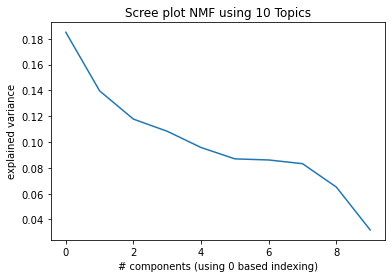

In [51]:
plt.plot(pca2.explained_variance_ratio_)
plt.xlabel('# components (using 0 based indexing)')
plt.ylabel('explained variance');
plt.title('Scree plot NMF using 10 Topics');

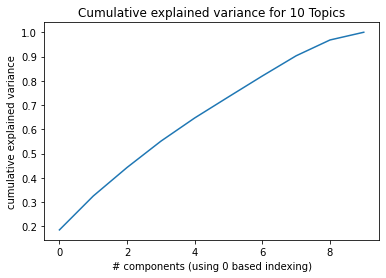

In [52]:
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('# components (using 0 based indexing)')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance for 10 Topics');

This cumulative explained variance plot suggest that we reach 70% of variance explained with 5 (aka 6 components).  The scree plot levels off between 5 and 7 (aka 6 and 8 components) topics. Before we choose 6 over 7, let's see how coherent separable each of these options looks on the eye check of the topics as well as t-SNE plots.

### 7 Components

In [53]:
nmf_model_7 = NMF(n_components=7, random_state=None)
nmf_model_7.fit(reviews_dtm_1)

NMF(n_components=7)

In [54]:
display_topics(model=nmf_model_7, feature_names=tfidf.get_feature_names(), no_top_words=15)


Topic  0
wear, like, strap, buy, long, feel, time, stretch, work, run, try, energy, find, lulu, wash

Topic  1
size, order, small, tight, buy, cup, band, return, big, little, usually, lulu, true, try, large

Topic  2
great, support, run, provide, high, workout, look, coverage, yoga, need, favorite, activity, impact, light, medium

Topic  3
love, color, absolutely, energy, perfect, different, style, design, favorite, white, come, black, line, new, pink

Topic  4
comfortable, supportive, soft, run, workout, wear, day, easy, stylish, definitely, flatter, extremely, amaze, favorite, recommend

Topic  5
fit, good, perfect, perfectly, find, like, nice, hold, snug, pad, look, fabric, hard, tight, place

Topic  6
cute, super, comfy, supportive, look, favorite, strap, tank, flatter, good, design, strappy, small, amaze, chest


In [55]:
topic_results_1 = nmf_model_7.transform(reviews_dtm_1)

In [56]:
topic_results_1.shape

(9090, 7)

In [57]:
# sklearn implements t-SNE.
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Import seaborn and matplotlib.patheffects to make nice plots.
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# Random state.
RS = 20200807

In [58]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("colorblind", 8))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [59]:
X = TSNE(random_state=RS).fit_transform(topic_results_1)
# X = topic_results
y = topic_results_1.argmax(axis=1)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


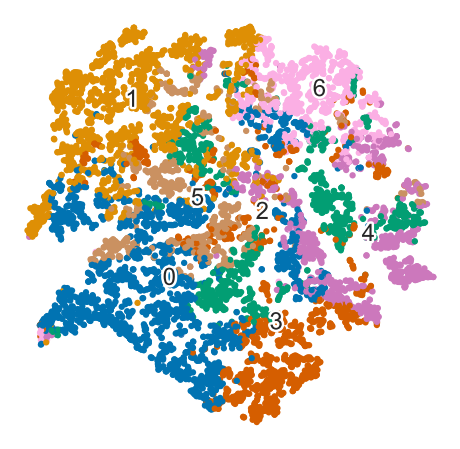

In [60]:
scatter(X, y);

### 6 components

In [61]:
nmf_model = NMF(n_components=6, random_state=None)
nmf_model.fit(reviews_dtm_1)

NMF(n_components=6)

In [62]:
display_topics(model=nmf_model, feature_names=tfidf.get_feature_names(), no_top_words=15)


Topic  0
wear, like, strap, buy, long, feel, time, stretch, look, work, try, energy, lulu, find, little

Topic  1
size, order, small, tight, buy, cup, band, return, big, little, usually, lulu, try, true, large

Topic  2
great, support, run, provide, look, high, workout, coverage, yoga, need, favorite, activity, impact, light, medium

Topic  3
love, color, absolutely, energy, perfect, different, style, design, favorite, cute, comfy, white, look, come, black

Topic  4
comfortable, supportive, super, cute, run, soft, wear, favorite, workout, flatter, definitely, amaze, recommend, comfy, stylish

Topic  5
fit, good, perfect, perfectly, find, like, nice, look, hold, snug, fabric, pad, tight, hard, place


In [63]:
topic_results = nmf_model.transform(reviews_dtm_1)

In [64]:
X = TSNE(random_state=RS).fit_transform(topic_results)
y = topic_results.argmax(axis=1)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


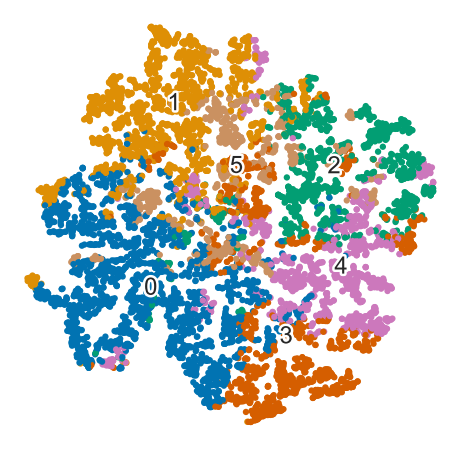

In [65]:
tsne_fig = scatter(X, y);
with open('tsne_fig.pickle', 'wb') as f:
    pickle.dump(tsne_fig, f) 

Comparing the two t-SNE plots alongside the eye check of the topics, I would say that 6 components is offering comparatively better topics and are more separable than the model using 7, so let's proceed from here using 6 topics.

# Send 6 topics back to dataframe

In [66]:
topic_results = nmf_model.transform(reviews_dtm_1)
clean_df['NMF_Topic'] = topic_results.argmax(axis=1)

In [67]:
clean_df_t = clean_df.reset_index()
clean_df_t.head()

,index,product_name,product_url,product_list_price,product_avg_rating,title,content,rating,name,date,review counter,num_total_ratings,rev_length,clean_txt,NMF_Topic
0,0,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Haven't taken it off,I purchased this bra in the hazy jade color ab...,5,Anonymous,2020-10-31,1,89,203,purchase hazy jade color week ago wear everyda...,3
1,1,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,"comfortable, but...","comfortable, but not for small frame/big chest...",3,Ashley Traister,2020-10-31,2,89,107,comfortable small framebig chest strap dig sho...,4
2,2,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Amazing,"If it weren't for the price, I would replace a...",5,meaglee321,2020-10-31,3,89,170,price replace amaze material like cloud accura...,0
3,3,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Comfort Bra 5*’s,Super soft and comfortable to wear all day. Ot...,5,Craftybayler,2020-10-30,4,89,111,super soft comfortable wear day rub tight wear...,4
4,4,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,So comfortable!,I originally bought 2 but I’m buying more. I w...,5,Ash the mail lady,2020-10-30,5,89,324,originally buy buy wear work mail carrier walk...,0


In [68]:
clean_df_t.shape

(9090, 15)

In [69]:
topics=pd.DataFrame(topic_results, columns=['Topic_'+str(x) for x in range(topic_results.shape[1])]) 

In [70]:
# reset index to create an index column that we can later use for merge
topics = topics.reset_index()

In [71]:
topics.shape

(9090, 7)

In [72]:
topics.head()

,index,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0,0.044743,0.000000,0.0,0.070534,0.000000,0.000000
1,1,0.051651,0.020673,0.0,0.000000,0.065041,0.000000
2,2,0.025285,0.003833,0.0,0.000000,0.001653,0.003497
3,3,0.038130,0.008928,0.0,0.000000,0.107020,0.000000
4,4,0.048789,0.004549,0.0,0.013838,0.029800,0.000784


In [73]:
final_df = clean_df_t.merge(topics, on='index', how='left')

In [74]:
final_df.head()

,index,product_name,product_url,product_list_price,product_avg_rating,title,content,rating,name,date,...,num_total_ratings,rev_length,clean_txt,NMF_Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5
0,0,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Haven't taken it off,I purchased this bra in the hazy jade color ab...,5,Anonymous,2020-10-31,...,89,203,purchase hazy jade color week ago wear everyda...,3,0.044743,0.000000,0.0,0.070534,0.000000,0.000000
1,1,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,"comfortable, but...","comfortable, but not for small frame/big chest...",3,Ashley Traister,2020-10-31,...,89,107,comfortable small framebig chest strap dig sho...,4,0.051651,0.020673,0.0,0.000000,0.065041,0.000000
2,2,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Amazing,"If it weren't for the price, I would replace a...",5,meaglee321,2020-10-31,...,89,170,price replace amaze material like cloud accura...,0,0.025285,0.003833,0.0,0.000000,0.001653,0.003497
3,3,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,Comfort Bra 5*’s,Super soft and comfortable to wear all day. Ot...,5,Craftybayler,2020-10-30,...,89,111,super soft comfortable wear day rub tight wear...,4,0.038130,0.008928,0.0,0.000000,0.107020,0.000000
4,4,"Like a Cloud Bra Light Support, B/C Cup",https://shop.lululemon.com/p/women-sports-bras...,58.0,4.6,So comfortable!,I originally bought 2 but I’m buying more. I w...,5,Ash the mail lady,2020-10-30,...,89,324,originally buy buy wear work mail carrier walk...,0,0.048789,0.004549,0.0,0.013838,0.029800,0.000784


Pickle final_df for topic interpretation and exploration in the next notebook.

In [75]:
with open('final_df.pickle', 'wb') as to_write:
    pickle.dump(final_df, to_write)

In [76]:
vocab = tfidf.get_feature_names()

In [77]:
word_topic_matrix = pd.DataFrame(nmf_model.components_, columns=vocab).T.add_prefix('topic_')
word_topic_matrix.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
ability,0.010288,0.000000,0.008263,0.002557,0.000000,0.0
able,0.141506,0.040597,0.000000,0.000000,0.000000,0.0
absolute,0.020483,0.007391,0.020545,0.010795,0.032042,0.0
absolutely,0.037562,0.000000,0.000000,0.360879,0.039375,0.0
accept,0.005527,0.005591,0.000000,0.000000,0.000000,0.0


Pickle word_topic_matrix for topic interpretaiton and exploration in the next notebook.

In [78]:
with open('word_topic_matrix.pickle', 'wb') as to_write:
    pickle.dump(word_topic_matrix, to_write)